# AutoEncoder

In [159]:
# importer
import os
import sys
import time
import random
import torch
import torch.nn as nn
import torchvision.transforms as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, models
from typing import Tuple
sys.path.append(os.path.abspath(".."))
from ml_utils import parse_config, vizualization, print_step

### Scheme of valid json configuration

In [160]:
VALID_JSON = {
    "data":
    {
        "type":"object",
        "properties":
        {
            "dataset":
            {
                "type":"string"
            },
            "batch_size":
            {
                "type":"int"
            },
            "test_path":
            {
                "type":"string"
            },
            "train_path":
            {
                "type":"string"
            },
            "in_channels":
            {
                "type":"integer"
            },
            "buffer_channels":
            {
                "type":"integer"
            }
        },
        "required":["dataset", "batch_size", "test_path", "train_path", "in_channels", "buffer_channels"]
    },
    "hpr_prm":
    {
        "lr":
        {
            "type":"number"
        },
        "epochs":
        {
            "type":"int"
        },
        "required":["lr", "epochs"]
    },
    "opt":
    {
        "type":"object",
        "properties":
        {
            "displ":
            {
                "type":"object",
                "properties":
                {
                    "flag":
                    {
                        "type":"boolean"
                    },
                    "step":
                    {
                        "type":"integer"
                    }
                },
                "required":["flag", "step"]
            },
            "store":
            {
                "type":"object",
                "properties":
                {
                    "flag":
                    {
                        "type":"boolean"
                    },
                    "path":
                    {
                        "type":"string"
                    }
                },
                "required":["flag", "path"]
            },
            "load":
            {
                "type":"object",
                "properties":
                {
                    "flag":
                    {
                        "type":"boolean"
                    },
                    "req_grad":
                    {
                        "type":"boolean"
                    },
                    "path":
                    {
                        "type":"string"
                    }
                },
                "required":["flag", "req_grad", "path"]
            }
        },
        "required":["displ", "store", "load"]
    },
    "required":["data", "hpr_prm", "opt"]   
}

### Work with data

In [161]:
def get_dataset(train_path:str, test_path:str, batch_size:int)->Tuple[DataLoader, DataLoader]:
    transforms = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
        ]
    )
    train_loader = DataLoader(
        dataset=datasets.CIFAR10(root=train_path, train=True, transform=transforms, download=True),
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        dataset=datasets.CIFAR10(root=test_path, train=False, transform=transforms, download=True),
        batch_size=batch_size,
        shuffle=False
    )
    return train_loader, test_loader

### Autoencoder model (CNN)

In [162]:
class FullConnected(nn.Module):
    def __init__(self, data_size:int):
        super().__init__()
        self.l1 = nn.Linear(data_size, data_size)
        self.act_1 = nn.ReLU()

    def forward(self, x):
        out = self.act_1(self.l1(x))
        return out

class Encoder(nn.Module):
    def __init__(self, in_channels:int, out_channels:int):
        super().__init__()
        self.in_channels = in_channels
        
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(16)
        self.act_1 = nn.ReLU()
        self.max_pool_1 = nn.MaxPool2d(2, 2, return_indices=True)
        
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.act_2 = nn.ReLU()
        self.max_pool_2 = nn.MaxPool2d(2, 2, return_indices=True)
        
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=3, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(out_channels)
        self.act_3 = nn.ReLU()
        self.max_pool_3 =nn.MaxPool2d(2, 2, return_indices=True)
    def freezer(flag_freez:bool):
        pass
    def forward(self, x):
        indices = []
        out, ind = self.max_pool_1(self.act_1(self.batch_norm_1(self.conv_1(x))))
        indices.append(ind)
        out, ind = self.max_pool_2(self.act_2(self.batch_norm_2(self.conv_2(out))))
        indices.append(ind)
        out, ind = self.max_pool_3(self.act_3(self.batch_norm_3(self.conv_3(out))))
        indices.append(ind)
        return out, indices
    
class Decoder(nn.Module):
    def __init__(self, in_channels:int, out_chanels:int):
        super().__init__()
        
        self.un_pool_1 = nn.MaxUnpool2d(2, 2)
        self.un_conv_1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.act_1 = nn.ReLU()
        
        self.un_pool_2 = nn.MaxUnpool2d(2, 2)
        self.un_conv_2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.act_2 = nn.ReLU()
        
        self.un_pool_3 = nn.MaxUnpool2d(2, 2)
        self.un_conv_3 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        self.act_3 = nn.ReLU()
        
        self.un_conv_4 = nn.ConvTranspose2d(in_channels=8, out_channels=out_chanels, kernel_size=3, padding=1)
        #self.sig_4 = nn.Sigmoid()
        
    def forward(self, x, indices):
        out =self.act_1(self.un_conv_1(self.un_pool_1(x, indices[2])))
        out = self.act_2(self.un_conv_2(self.un_pool_2(out, indices[1])))
        out = self.act_3(self.un_conv_3(self.un_pool_3(out, indices[0])))
        out = self.un_conv_4(out)
        return out

class AutoEncoder(nn.Module):
    def __init__(self, in_channels:int, buffer_channels:int):
        super().__init__()
        self.in_channels = in_channels
        self.buffer_channels = buffer_channels
        
        self.encoder = Encoder(in_channels=self.in_channels, out_channels=self.buffer_channels)
        self.decoder = Decoder(in_channels=self.buffer_channels, out_chanels=self.in_channels)
        #self.full_conn = FullConnected(data_size=1024)

    def forward(self, x):
        out_encode, indices = self.encoder(x)
        #print(out_encode.size())
        #out_encode = out_encode.view(-1, 1024)
        #out_full_conn = self.full_conn(out_encode)
        #out_full_conn = out_full_conn.view(-1, 64, 4, 4)
        out_decode = self.decoder(out_encode, indices)
        return out_decode  


### Learning process of autoencoder

In [163]:
def train_autoencoder(device:torch.device, model:nn.Module, optimizer:Adam, criterion, loader:DataLoader, epochs: int, displ_conf:dict)->None:
    if displ_conf['flag']:
        x_epoch = np.arange(0,epochs)
        y_loss = np.zeros(epochs)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        loss = None
        for data, _ in loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        running_loss = running_loss/len(loader)
        y_loss[epoch] = running_loss
        if displ_conf['flag']and epoch % displ_conf['step'] == 0:
            print(f'Epoch [{epoch}/{epochs}] finished with avg loss: {running_loss}')
    if displ_conf['flag']:
        vizualization(x=x_epoch, x_label='Epochs', y=y_loss, y_label='Loss', title='Loss throw epochs')


In [164]:
def test_autoencoder(device:torch.device, model:nn.Module, criterion:nn.MSELoss, loader:DataLoader)->None:
    model.eval()
    batch_index = random.randint(0, len(loader)-1)
    with torch.no_grad():
        test_loss = 0.0
        loss = 0.0
        last_img = None
        last_output = None
        for i, (data, _) in enumerate(loader):
            data = data.to(device)
            output = model(data)
            loss += criterion(output, data).item()
            if i == (batch_index):
                image_index = random.randint(0, len(data)-1)
                last_image = data[image_index].cpu()
                last_output = output[image_index].cpu()
        test_loss = loss / len(loader)
        print(f'Average loss in test time is : {test_loss}')
        last_image = last_image.permute(1, 2, 0).numpy()
        last_output = last_output.permute(1, 2, 0).numpy()

        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 1, 3)
        std = torch.tensor([0.2470, 0.2435, 0.2616]).view(1, 1, 3)

        last_image = last_image * std.numpy() + mean.numpy()
        last_output = last_output * std.numpy() + mean.numpy()

        last_image = last_image.clip(0, 1)
        last_output = last_output.clip(0, 1)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(last_image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(last_output)
        plt.axis('off')

        plt.show()
        

In [165]:
def learn_autoencoder(config:dict)->None:
    torch.cuda.empty_cache()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'device :{device}')
    print_step('DATA')
    train_loader, test_loader = get_dataset(train_path=config['data']['train_path'],
                                            test_path=config['data']['test_path'], 
                                            batch_size=config['data']['batch_size'])
    print_step('MODEL')
    model = AutoEncoder(in_channels=config['data']['in_channels'], buffer_channels=config['data']['buffer_channels']).to(device)
    if config['opt']['load']['flag']:
        model.load_state_dict(state_dict=config['opt']['load']['path'])
    optimizer = Adam(params=model.parameters(), lr=config['hpr_prm']['lr'])
    criterion = nn.MSELoss()
    print_step('TRAIN')
    train_autoencoder(device=device,
          model=model, 
          optimizer=optimizer, 
          criterion=criterion, 
          loader=train_loader, 
          epochs=config['hpr_prm']['epochs'], 
          displ_conf=config['opt']['displ'])
    print_step('TEST')
    test_autoencoder(device=device, 
         model=model, 
         criterion=criterion, 
         loader=test_loader)
    if config['opt']['store']['flag']:
        torch.save(model.state_dict(), config['opt']['store']['path'])

### Self-supervised pretrain

device :cuda
			 DATA


100%|██████████| 170498071/170498071 [00:28<00:00, 6064608.84it/s] 


Extracting data/pretrain/train\cifar-10-python.tar.gz to data/pretrain/train
Files already downloaded and verified
			 MODEL
			 TRAIN
Epoch [0/100] finished with avg loss: 0.17506569017039236
Epoch [10/100] finished with avg loss: 0.039678041122929976
Epoch [20/100] finished with avg loss: 0.03342172779533488
Epoch [30/100] finished with avg loss: 0.030301185879770598
Epoch [40/100] finished with avg loss: 0.02890244811830466
Epoch [50/100] finished with avg loss: 0.027676548149027026
Epoch [60/100] finished with avg loss: 0.027023963051397936
Epoch [70/100] finished with avg loss: 0.026422579856136875
Epoch [80/100] finished with avg loss: 0.025682866216048865
Epoch [90/100] finished with avg loss: 0.025764306557014623


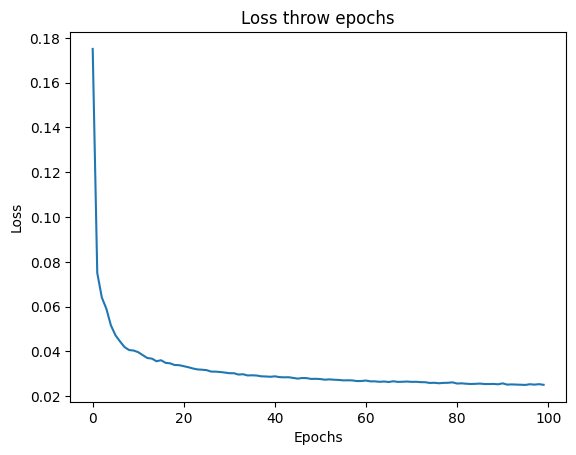

			 TEST
Average loss in test time is : 0.023530590116598044


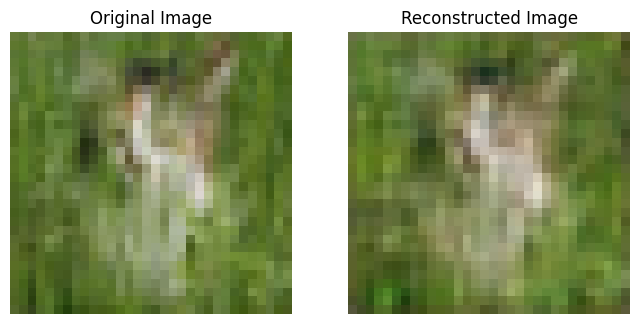

In [166]:
config = parse_config('config/config1.json', VALID_JSON)
learn_autoencoder(config)

### CNN classificator model with embedded self-supervised CNN autoencoder

In [167]:
class Clasificator(nn.Module):
    def __init__(self, req_grad:bool, encoder:Encoder):
        super().__init__()
        self.encoder = encoder
        self.mixin = nn.Sequential(
            nn.Linear(in_features=1024, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=4906),
            nn.ReLU(),
            nn.Linear(in_features=4906, out_features=10)
        )
        self.freez(req_grad)
    
    def freez(self, req_grad:bool):
        print(f'Set req_grad for encoder on : {req_grad}')
        for param in self.encoder.parameters():
            param.requires_grad = req_grad
        self.freez = req_grad
    
    def forward(self, x):
        out_encode, _ = self.encoder(x)
        out_encode = out_encode.view(-1, 1024)
        out_encode = torch.flatten(out_encode, 1)
        out = nn.LogSoftmax(dim=1)(self.mixin(out_encode))
        #out = self.mixin(out_encode)
        return out


In [168]:
def train(device:torch.device, model:nn.Module, optimizer:Adam, criterion, loader:DataLoader, epochs: int, displ_conf:dict)->None:
    if displ_conf['flag']:
        x_epoch = np.arange(0,epochs)
        y_loss = np.zeros(epochs)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        loss = None
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        running_loss = running_loss/len(loader)
        y_loss[epoch] = running_loss
        if displ_conf['flag']and epoch % displ_conf['step'] == 0:
            print(f'Epoch [{epoch}/{epochs}] finished with avg loss: {running_loss}')
    if displ_conf['flag']:
        vizualization(x=x_epoch, x_label='Epochs', y=y_loss, y_label='Loss', title='Loss throw epochs')


In [169]:
def test(device:torch.device, model:nn.Module, loader:DataLoader)->None:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
        

In [170]:
def learn(config:dict):
    torch.cuda.empty_cache()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'device : {device}')
    print_step('DATA')
    train_loader, test_loader = get_dataset(train_path=config['data']['train_path'], test_path=config['data']['test_path'], batch_size=config['data']['batch_size'])
    print_step('LOAD EMBEDDEED ENCODER MODEL')
    autoencoder = AutoEncoder(in_channels=config['data']['in_channels'], buffer_channels=config['data']['buffer_channels']).to(device)
    if config['opt']['load']['flag']:
      autoencoder.load_state_dict(torch.load(config['opt']['load']['path']))
    encoder = autoencoder.encoder
    print_step('BUILD MODEL')
    model = Clasificator(req_grad=config['opt']['load']['req_grad'], encoder=encoder).to(device)
    optimizer = Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=config['hpr_prm']['lr'])
    criterion = nn.CrossEntropyLoss()
    print_step('TRAIN')
    train(device=device,
          model=model, 
          optimizer=optimizer, 
          criterion=criterion, 
          loader=train_loader, 
          epochs=config['hpr_prm']['epochs'], 
          displ_conf=config['opt']['displ'])
    print_step('TEST')
    test(device=device,
         model=model,
         loader=test_loader)
    

### Classification with pretrained data

device : cuda
			 DATA


100%|██████████| 170498071/170498071 [00:21<00:00, 7939332.57it/s]


Extracting data/learn/train\cifar-10-python.tar.gz to data/learn/train


100%|██████████| 170498071/170498071 [00:22<00:00, 7483603.95it/s] 


Extracting data/learn/test\cifar-10-python.tar.gz to data/learn/test
			 LOAD EMBEDDEED ENCODER MODEL
			 BUILD MODEL
Set req_grad for encoder on : False
			 TRAIN


C:\Users\user\AppData\Local\Temp\ipykernel_8232\2287305648.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(config['opt']['load'][

Epoch [0/25] finished with avg loss: 1.2788739506241
Epoch [5/25] finished with avg loss: 0.6697093804397851
Epoch [10/25] finished with avg loss: 0.28512721515410694
Epoch [15/25] finished with avg loss: 0.13328881841391096
Epoch [20/25] finished with avg loss: 0.09265691949747731


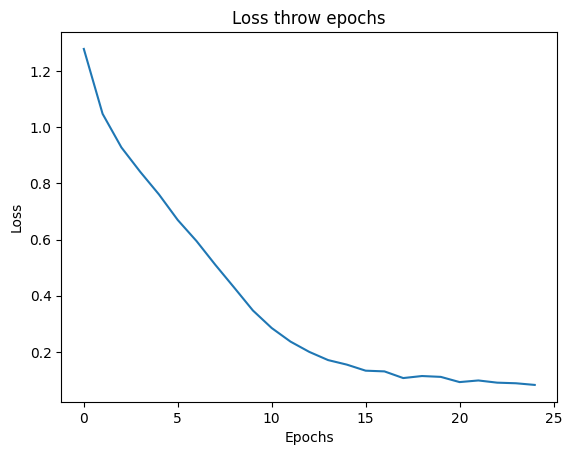

			 TEST
Accuracy on test set: 66.80%


In [171]:
config = parse_config('config/config2.json', VALID_JSON)
learn(config=config)

### Classification without pretrained data

device : cuda
			 DATA
Files already downloaded and verified
Files already downloaded and verified
			 LOAD EMBEDDEED ENCODER MODEL
			 BUILD MODEL
Set req_grad for encoder on : True
			 TRAIN
Epoch [0/25] finished with avg loss: 1.2910197730869284
Epoch [5/25] finished with avg loss: 0.523254181360802
Epoch [10/25] finished with avg loss: 0.2761416736027926
Epoch [15/25] finished with avg loss: 0.15319806004843445
Epoch [20/25] finished with avg loss: 0.1092546694212929


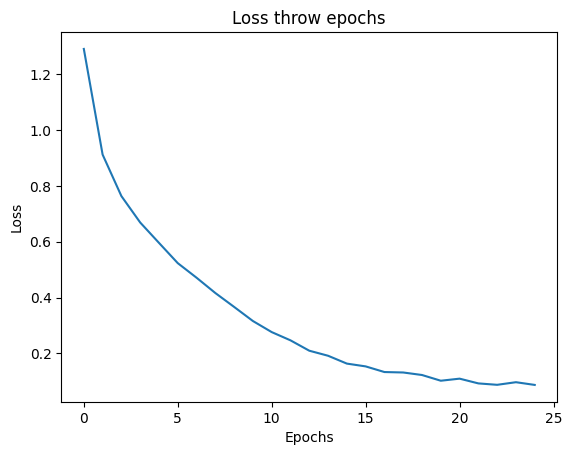

			 TEST
Accuracy on test set: 75.23%


In [172]:
config = parse_config('config/config3.json', VALID_JSON)
learn(config=config)